In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)

In [2]:
import numpy as np
import pandas as pd

class Backpropagation:
    def __init__(self, input_size, hidden_size1, hidden_size2, output_size):
        self.input_size = input_size
        self.hidden_size1 = hidden_size1
        self.hidden_size2 = hidden_size2
        self.output_size = output_size

        self.weights_input_hidden1 = np.random.randn(self.input_size, self.hidden_size1)
        self.weights_hidden1_hidden2 = np.random.randn(self.hidden_size1, self.hidden_size2)
        self.weights_hidden2_output = np.random.randn(self.hidden_size2, self.output_size)

        self.bias_hidden1 = np.zeros((1, self.hidden_size1))
        self.bias_hidden2 = np.zeros((1, self.hidden_size2))
        self.bias_output = np.zeros((1, self.output_size))

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def sigmoid_derivative(self, x):
        return x * (1 - x)

    def feedforward(self, X):
        self.hidden1_activation = np.dot(X, self.weights_input_hidden1) + self.bias_hidden1
        self.hidden1_output = self.sigmoid(self.hidden1_activation)

        self.hidden2_activation = np.dot(self.hidden1_output, self.weights_hidden1_hidden2) + self.bias_hidden2
        self.hidden2_output = self.sigmoid(self.hidden2_activation)

        self.output_activation = np.dot(self.hidden2_output, self.weights_hidden2_output) + self.bias_output
        self.predicted_output = self.sigmoid(self.output_activation)

        return self.predicted_output

    def backward(self, X, y, learning_rate):
        output_error = y - self.predicted_output
        output_delta = output_error * self.sigmoid_derivative(self.predicted_output)

        hidden2_error = np.dot(output_delta, self.weights_hidden2_output.T)
        hidden2_delta = hidden2_error * self.sigmoid_derivative(self.hidden2_output)

        hidden1_error = np.dot(hidden2_delta, self.weights_hidden1_hidden2.T)
        hidden1_delta = hidden1_error * self.sigmoid_derivative(self.hidden1_output)

        self.weights_hidden2_output += np.dot(self.hidden2_output.T, output_delta) * learning_rate
        self.bias_output += np.sum(output_delta, axis=0, keepdims=True) * learning_rate

        self.weights_hidden1_hidden2 += np.dot(self.hidden1_output.T, hidden2_delta) * learning_rate
        self.bias_hidden2 += np.sum(hidden2_delta, axis=0, keepdims=True) * learning_rate

        self.weights_input_hidden1 += np.dot(X.T, hidden1_delta) * learning_rate
        self.bias_hidden1 += np.sum(hidden1_delta, axis=0, keepdims=True) * learning_rate

    def train(self, X, y, epochs, learning_rate):
        for epoch in range(epochs):
            output = self.feedforward(X)
            self.backward(X, y, learning_rate)
            if epoch % 4000 == 0:
                loss = np.mean(np.square(y - output))
                print(f"Epoch {epoch}, Loss:{loss}")


In [3]:
df = pd.read_csv('obesity-dataset-preprocessed.csv')
df.shape

(2063, 21)

Epoch 0, Loss:0.30129707464061023
Epoch 4000, Loss:0.05109853105506041
Epoch 8000, Loss:0.04335117409337784
Epoch 12000, Loss:0.03945808489132886
Epoch 16000, Loss:0.03661695539779826
Fold Accuracy: 0.9304738844690419
              precision    recall  f1-score   support

           0       0.53      0.91      0.67        54
           1       0.62      0.40      0.49        57
           2       0.81      0.73      0.77        70
           3       0.78      0.83      0.80        59
           4       0.88      0.95      0.91        60
           5       0.66      0.56      0.61        55
           6       0.78      0.62      0.69        58

    accuracy                           0.72       413
   macro avg       0.72      0.71      0.71       413
weighted avg       0.73      0.72      0.71       413

Epoch 0, Loss:0.31407268971053187
Epoch 4000, Loss:0.056641658111170785
Epoch 8000, Loss:0.0468708496504569
Epoch 12000, Loss:0.04184037118159144
Epoch 16000, Loss:0.03867499608660796
F

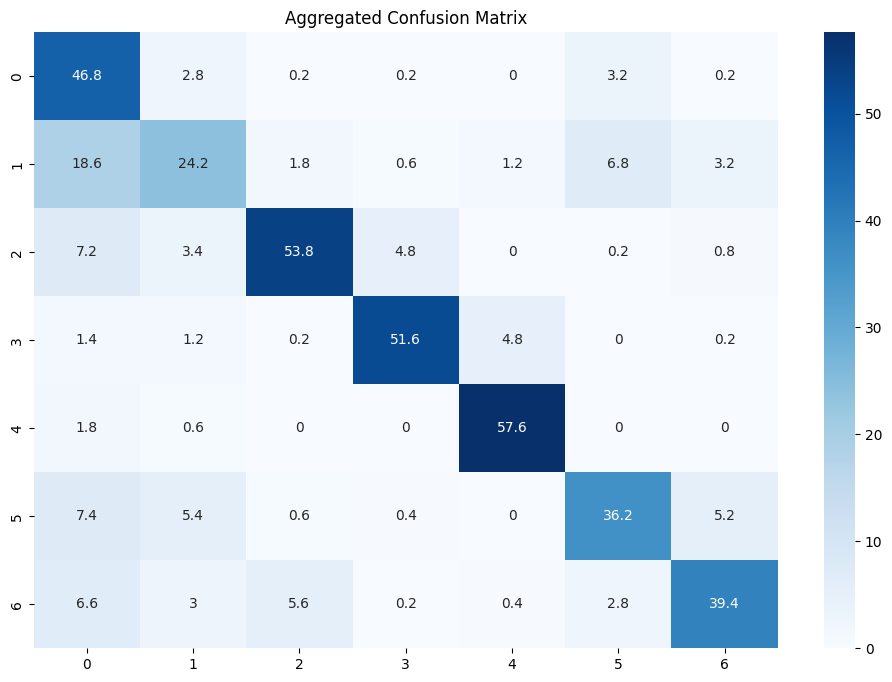

In [4]:
# Memisahkan fitur dan target
X = df.drop('NObeyesdad', axis=1)
y = df['NObeyesdad']

# Convert labels to one-hot encoding
y_one_hot = pd.get_dummies(y).to_numpy()

# Convert features to numpy
X = X.to_numpy()

# Scaling features (Hanya data pelatihan yang di-fit oleh scaler)
scaler = StandardScaler()

# Initialize cross-validation
n_splits = 5
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Model parameters
input_size = X.shape[1]
hidden_size = 10
output_size = y_one_hot.shape[1]

# Placeholder for overall metrics
accuracies = []
classification_reports = []
confusion_matrices = []

# Cross-validation loop
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y_one_hot[train_index], y_one_hot[test_index]

    # Scaling the features (fit scaler only on training data)
    X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform on train
    X_test_scaled = scaler.transform(X_test)        # Only transform on test

    # Initialize and train the neural network with ReLU and Softmax
    nn = Backpropagation(input_size, hidden_size, hidden_size, output_size)  # Coba dengan softmax
    nn.train(X_train_scaled, y_train, epochs=20000, learning_rate=0.0005)

    # Generate predictions
    output = nn.feedforward(X_test_scaled)
    output = np.round(output)  # Round output to get 0 or 1

    # Calculate accuracy
    accuracy = np.mean(output == y_test)
    accuracies.append(accuracy)

    # Store classification report and confusion matrix
    classification_reports.append(classification_report(y_test.argmax(axis=1), output.argmax(axis=1), output_dict=True))
    confusion_matrices.append(confusion_matrix(y_test.argmax(axis=1), output.argmax(axis=1)))

    print(f"Fold Accuracy: {accuracy}")
    print(classification_report(y_test.argmax(axis=1), output.argmax(axis=1)))

# Average accuracy across folds
print(f"Average Accuracy: {np.mean(accuracies)}")

# Aggregate confusion matrix
average_cm = np.mean(confusion_matrices, axis=0)

# Plot aggregated confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(average_cm, annot=True, fmt='g', cmap='Blues')
plt.title("Aggregated Confusion Matrix")
plt.show()
